# Noise in Phase Field Models
## Vera Titze Undergraduate Research Report Spring 2019

## I. Brownian Motion and Langevin Equations
- One source of noise in phase field models is a result of random motion of molecules (Brownian Motion)
- The amplitude of this noise needs to be found and incorporated into our model
- The fluctuation dissipation theorem$^{[1]}$ states that the expected noise $\eta$ in the phase field and in the concentration behave according to the following equations (called the Langevin equations):
$$\left\langle\eta_{\psi}(\vec{x}, t) \eta_{\psi}(\vec{x}', t')\right\rangle= 2 \Gamma_{\psi} k_{b} T \delta(\vec{x}-\vec{x}') \delta(t-t')$$
$$\left\langle\eta_{c}(\vec{x}, t) \eta_{c}(\vec{x}', t')\right\rangle=2 \Gamma_{c} k_{b} T \nabla^{2} \delta(\vec{x}-\vec{x}') \delta(t-t')$$
- Since $\left\langle\eta_{\psi}(\vec{x}, t)\right\rangle=0$ and $\left\langle\eta_{c}(\vec{x}, t)\right\rangle=0$ from the assumption that the statistical distribution of motion is centered about zero, the standard deviation of each noise term is equal to the square root of the RHS in each of the above equations. This follows from the general formula of the standard deviation:
$$\sigma^2=var(x)=\left\langle x^2\right\rangle-\left\langle x\right\rangle^2$$ for the case when $\vec{x}=\vec{x}'$ and $t=t'$, This implies that one specific cell at one single timestep is independent from the cells around and the previous timestep.
- Kosterlitz and Grant $^{[2]}$ proceed to add this noise term outside the functional:
$$ \frac{\partial \psi}{\partial t}=-\Gamma_{\psi} \frac{\delta \mathcal{F}}{\delta \psi}+\eta_{\psi}$$
$$ \frac{\partial c}{\partial t}=\Gamma_{c} \nabla^{2} \frac{\delta \mathcal{F}}{\delta c}+\eta_{c} $$
- When incorporating Langevin Noise into a Multicomponent Model for Solidification, we suspect that the approximations needed when adding the noise outside the functional could be an oversimplification. Therefore both adding the noise inside and outside the functional were investigated and compared.

In [1]:
import numpy as np
from scipy.constants import R
from noise_utils import plotImages_c, plotImages, plotImages_q
import matplotlib.pyplot as plt
#set up initial conditions for demonstration of noise
T=np.full((50, 50), 1574)
phi=np.full((50, 50), 0.5)
c1=np.full((50, 50), 0.5)
c2=np.full((50, 50), 0.5)

dt=10**(-5)

### I.I. Adding noise outside the functional
- The noise term outside the functional is demonstrated below
- The molar gas constant $R$ was used instad of $k_B$ to be consistent with our expression of the mobility $\Gamma$, here $M$.

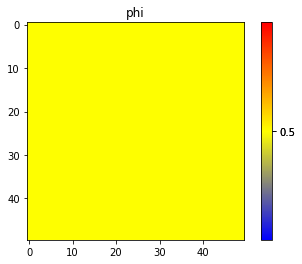

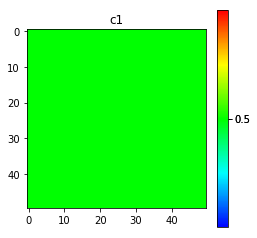

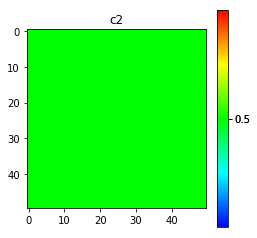

In [2]:
plotImages_c(phi, c1, c2)

In [3]:
#find noise
M_A=2
M_B=1
M_phi=1
v_m=7
#standard deviation of noise in phi and c according to Kosterlitz and Grant paper
std_c1=np.absolute(np.sqrt(2*R*M_A*T/v_m))
std_c2=np.absolute(np.sqrt(2*R*M_B*T/v_m))
std_phi=np.absolute(np.sqrt(2*R*M_phi*T/v_m))
#random Gaussian generation via Box-Muller transform [3]
r1=np.random.random((len(phi), len(phi[0])))
r2=np.random.random((len(phi), len(phi[0])))
th=np.random.random((len(phi), len(phi[0])))
#find random motion 
noise_c1_help=np.sqrt(-2*np.log(r1))*np.cos(2*np.pi*th)*std_c1
noise_c2_help=np.sqrt(-2*np.log(r1))*np.sin(2*np.pi*th)*std_c2
#bring into agreement with the energy functional
noise_c1=noise_c1_help-c1*noise_c1_help-c2*noise_c2_help
noise_c2=noise_c2_help-c1*noise_c1_help-c2*noise_c2_help    
noise_phi=np.sqrt(-2*np.log(r2))*np.sin(2*np.pi*th)*std_phi

#apply changes: in addition to the change from the simulation (not shown here), the noise needs to be added
c1 += noise_c1*dt
c2 += noise_c2*dt
phi += noise_phi*dt

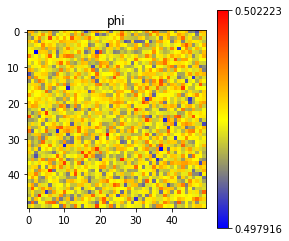

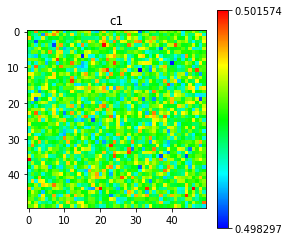

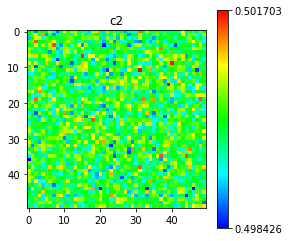

In [4]:
plotImages_c(phi, c1, c2)

### I.II. Adding Noise inside the functional
- In this case, the noise in the concentration is added to the change in free energy with respect to concentration
- The example below is a code snippet from the n component model

The noise has to be added into dFdc for each component separately but the standart deviation is a constant array
```python
#find the standard deviation as an array 
std_c=np.sqrt(np.absolute(2*R*T/v_m))
for j in range(len(c)):
    #find the actual random noise
    noise_c=np.random.normal(0, std_c, phi.shape)
    M_c.append(v_m*c[j]*(D_S+m*(D_L-D_S))/R/1574.)
    #add the change in noise inside the functional
    dFdc.append((dGSdc[j] + m*(dGLdc[j]-dGSdc[j]))/v_m + (W[j]-W[len(c)])*g*T+noise_c)
```
The noise in phi is added later:
```python
#noise in phi
std_phi=np.sqrt(np.absolute(2*R*M_phi*T/v_m))
noise_phi=np.random.normal(0, std_phi, phi.shape)
deltaphi += noise_phi
```

### I.III. Results

a) Noise outside the energy functional:
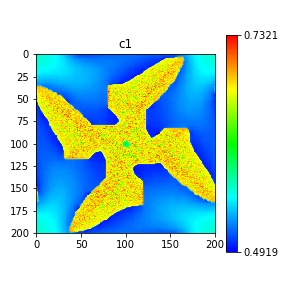
$$ Figure\_1$$

b) Noise inside the functional
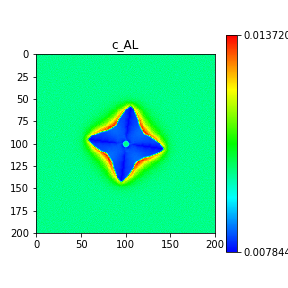
c) Old version of noise, same initial conditions and parameters used as Langevin noise inside functional
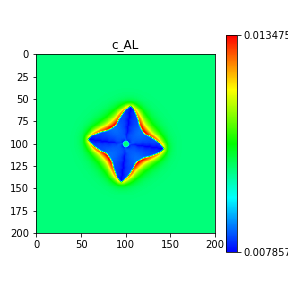
$$Figure\_2$$

## II. Brownian Motion in Spinodal Decomposition in the Context of Diffusion

- The governing equation for determining the decomposition behavior is$^{[4,5]}$ $$ 
F=\int_{V} \frac{\varepsilon}{2}|\nabla \varphi|^{2}+\varphi^{2}(1-\varphi)^{2} d V,
 $$
 
- This can be solved for the functional $$ 
f=2 \varphi-6 \varphi^{2}+4 \varphi^{3}-\varepsilon \nabla^{2} \varphi
 $$ This expression appears in the simulation code. The change in phase per time for a conserved approach is $$ 
\frac{d \varphi}{d t}=\nabla\cdot M \cdot \nabla f
 $$.
 
- An illustrative example is shown below for differnt amplitudes of Langevin noise added to the model.

In [5]:
## My simulation for conserved spinodal decompositon
def simulate(phi, m):
    #initial conditions & parameters
    M=0.25
    epsilon=0.25
    dt=0.025
    dx=1.
    inversexsq=1./(dx*dx) #write out functional and extract D from constant that shows up in from of (d/dx) term.
    laplacian=(np.roll(phi, 1, 0)+np.roll(phi, 1, 1)+np.roll(phi, -1, 0)+np.roll(phi, -1, 1)-4*phi)*inversexsq
    #find difference per timestep
    functional=phi*(2-phi*(6-4*phi))-epsilon*laplacian
    laplace_func=(np.roll(functional, 1, 0)+np.roll(functional, 1, 1)+np.roll(functional, -1, 0)+np.roll(functional, -1, 1)-4*functional)*inversexsq
    deltaphi=M*dt*laplace_func
    #standard deviation of noise and array generation, with a multiplication factor of m
    std=np.sqrt(2*M*m*300) #assume 300Kelvin for temperature
    r=np.random.random((len(phi), len(phi[0])))
    th=np.random.random((len(phi), len(phi[0])))
    noise=np.sqrt(-2*np.log(r))*np.cos(2*np.pi*th)*std*dt
    #update phi with noise
    phinew=phi+deltaphi+noise
    return phinew

### II.I. Demonstrating the Effect of altering Noise Amplitude
- The effect of noise was also investigated for spinodal decomposition
- The line in the simulation that determines the noise amplitude is the equation finding the standard deviation. 
- The ratio of the molar gas constant and the molar volume was assumed to be 1 for simplicity such that the distribution of the noise is $$\sigma=\sqrt{2Mm_iT}$$ where $T=300K$ and $m_i=10^{\frac{-i}{2}}$ is a multiplicative constant that allows to explore different levels of noise.

1 : new noise multiplication factor:  0.01


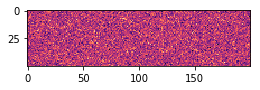

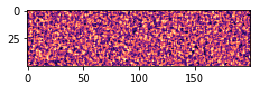

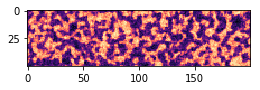

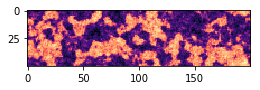

2 : new noise multiplication factor:  0.003162


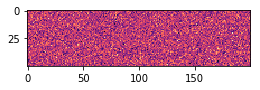

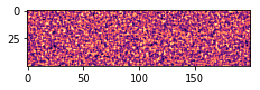

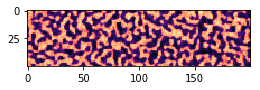

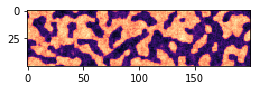

3 : new noise multiplication factor:  0.001


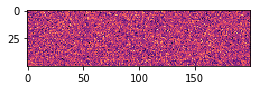

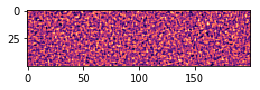

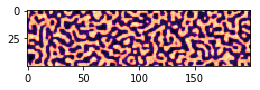

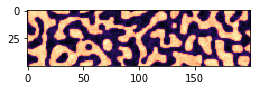

4 : new noise multiplication factor:  0.000316


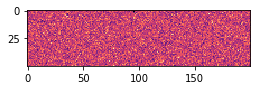

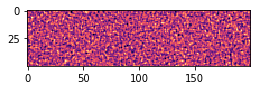

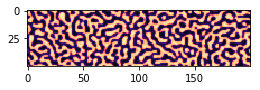

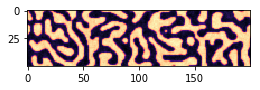

In [6]:
#create initial blank grid
grid0=np.full((50,200), 0.5)
for i in range (4,8):
    m_i=10**(-i/2)
    print(i-3,": new noise multiplication factor: ", round(m_i, 6))
    grid=simulate(grid0, m_i)
    #run simulations to compare different noise amplitudes
    for j in range(0,5):
        #only show select steps that are more spaced out as we progress
        for k in range(0, j**7):
            grid=simulate(grid, m_i)
        if (j!=1):
            plt.imshow(grid, cmap='magma')
            plt.show()
                

### II.II. Comparing the Amplitudes of Noise Flux and Flux expected from Diffusion
- Transport of species is driven by diffusion, but the noise also transports species. Therefore we were interested in the connection between these.
- Fick's law of diffusion states that $$ 
\frac{d \varphi}{d t}=D \nabla^{2} \varphi
 $$
 where the transport of a species depends on the local gradient as well as on the diffusion constant. 
- The following code investigates how the change in phase due to the noise term compares what is expected from Fick's law.
- A dimensional analysis is necessary to draw quantitative assumptions about the amplitudes, since the scaling needs to be consistent.

In [7]:
#===================================== FIND FLUXES 1D CASE ==============================
def find_expected_flux_x(grid, D, dx):
    #according to ficks law of diffusion
    return D*(np.roll(grid, -1, 0)+np.roll(grid, 1, 0)-2*grid)/(dx**2)

def add_noise(phi, m):
    #use the same approach to find the flux
    std=np.sqrt(2*m*M*300) #assume 300Kelvin for temperature
    r=np.random.random(len(phi))
    th=np.random.random(len(phi))
    noise=np.sqrt(-2*np.log(r))*np.cos(2*np.pi*th)*std
    return phi+noise

def find_time_flux_x(grid, dx, dt, m):
    grid2=add_noise(grid, m)
    return (grid2-grid)*dx/dt

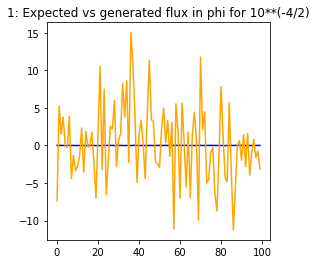

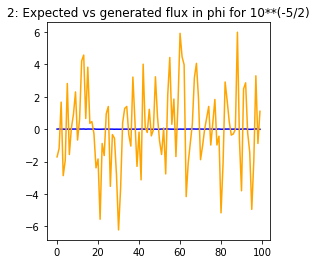

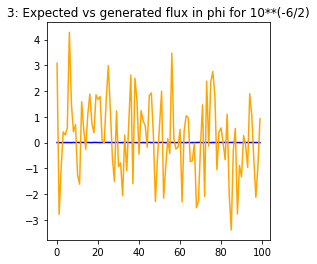

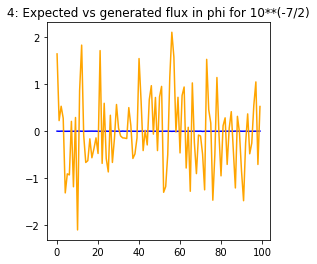

In [8]:
from matplotlib import rc
x=np.arange(0, 100, 1)
M=0.25 
epsilon=0.25

for i in range (4,8):
    m_i=10**(-i/2)
    phi=np.full((100,100), 0.5)
    #use the case after one run of simulation as initial condition
    phi=simulate(phi, m_i)
    plt.figure()
    plt.plot(x, find_expected_flux_x(phi, 2*M*epsilon, 1.)[0],label='expected', color='blue')
    plt.plot(x, find_time_flux_x(phi, 1., 0.25, m_i)[0],label='generated', color='orange')
    plt.title(str(i-3)+': Expected vs generated flux in phi for 10**(-'+ str(i)+'/2)')
    plt.show()

- This example illustrates that the noise is much larger than what is expected from diffusion
- However, this preliminary result has to be treated with caution since the scaling is not necessary consistent yey
- Previous work comparing Brownian motion and Diffusion$^{[5]}$ has made the argument that the expected transport of phase in Spinodal Decomposition should be a sum of the change driven by diffusion and the Brownian Motion Term.

## III. Stochastic Nucleation

- This method of randomly introducing nuclei into the phase field is based on the thermodynamic probability of forming a nucleus above the critical number of molecules for stability. The probability follows a Poisson distribution$^{[6]}$:$$ 
P_{n}=1-\exp \left(-J^{0 *} \Delta t\right)
 $$ where $J^{0 *}=k_{1} \chi \exp \left(-\frac{k_{2}}{\Delta T}\right)$ and $\chi=\chi_{0} \exp \left(-\frac{Q}{R T}\right)$.
- The code fragment I developed introduces a nucleus and then increases its radius.
- The nucleus needs to be added into the phase field as well as the orientation fields.
- The algorithm for adding nuclei into the phi and q fields of a simulation, as it is incorporated in the model, is shown below.
- A nucleus is introduced in a cell when a random number between 0 and 1 is smaller than a probabilistic threshold.

In [9]:
def add_nuclei(phi, q1, q4, p11, size1, size2):
    #generate random data between zero and 1 and compare it to a threshold probability
    random=np.random.random((size1, size2))
    nuclei_centers=np.argwhere(random<p11)
    print('number of nuclei added: ',len(nuclei_centers))
    #iterate through the list of nuclei to actually modify the fields
    for center in nuclei_centers:
        angle=np.random.random()
        for i in range((int)(center[0]-5), (int)(center[0]+5)):
            for j in range((int)(center[1]-5), (int)(center[1]+5)):
                #avoid out of bounds errors
                if (i>=0 and i<size-1 and j<size-1 and j>=0):
                    if((i-center[0])*(i-center[0])+(j-center[1])*(j-center[1]) < 25):
                        if(phi[i][j]<0.2): #avoid nucleating in the solid phase
                            #change the values at selected positions
                            phi[i][j] = 1
                            q1[i][j] = np.cos(angle*2*np.pi)
                            q4[i][j] = np.sin(angle*2*np.pi)
    return phi, q1, q4
           

- The algorithm for nucleation requires the computation of nucleation rates in order to find that probabilistic threshold
### Finding the nucleation probability

In [10]:
def find_Pn(T_M, T, Q ,dt):
    #finding the probability of forming a critical nucleus, nucleating only every 500 time steps
    #input: T_M -- temperature of the liquidus, T -- Temperature, Q -- activation energy for migration
    #choose free parameters a and b
    a=10**28 # k1 times \chi0 from above equation
    b=2.8*10**3 #k2 from above equation
    J0=a*e**(-b/(T_M-T))*e**(-Q/(R*T))
    Pn=1-e**(-J0*dt*500)
    return J0,Pn

### Nucleation probability for binary Ni-10%mol Cu alloy
- As a proof of concept, the result of the nucleation finding for the Ni-Cu alloy from work by Fu et al$^{[7]}$ was reproduced.

C:\Users\Vera\Anaconda3\envs\vera\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in power
  import sys


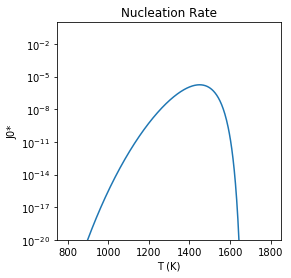

In [11]:
e=2.7182818284590452353
#parameters for Ni-Cu alloy from Fu et al
Q=8*10**5
Tm=1697
dt=10**(-6)
T=np.arange(800, 1800, 2)
y,p1=find_Pn(Tm, T, Q, dt)

#plotting the temperature dependance of J0*
plt.plot(T, y)
plt.yscale('log')
plt.title('Nucleation Rate')
plt.ylim(10**(-20),1)
plt.xlabel('T (K)')
plt.ylabel('J0*')
plt.show()


- From this curve, the throshold can be obtained.
- This quantity is plotted below.

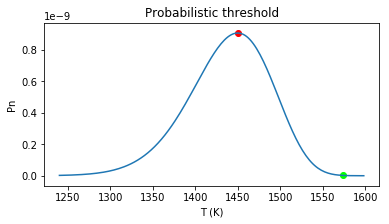

In [12]:
plt.figure(figsize=(6,3))
plt.plot(T[220:400], p1[220:400])
plt.title('Probabilistic threshold')
plt.xlabel('T (K)')
plt.ylabel('Pn')
plt.scatter(1450, find_Pn(Tm, 1450, Q, dt)[1], color='red')
plt.scatter(1574, find_Pn(Tm, 1574, Q, dt)[1], color='lime')           
plt.show()

### Investigating the Temperature dependence of nucleation probability
- The probabilistic threshold shows strong temperature dependence.
- I want to confirm that we can apply the algorithm to a grid with mixed temperatures and observe different nucleation rates for hotter and colder regions.
- A demonstration, using the nucleation rate J0 from the Nickel Copper for a mixed temperature grid, is carried out in the following code.
- The left side of the grid is at 1450 K, where the probabilistic threshold is maximized (red scatter in plot).
- The right side is run at a less probable temperature for nucleation, 1574K, a temperature frequently encountered in our phase field models (green scatter).

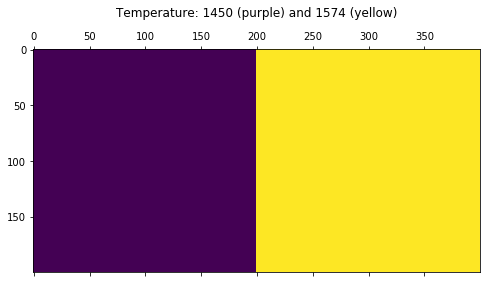

In [13]:
dt=1
size=200
#making an array for the temperature
T1=np.full((200, 200), 1450)
T2=np.full((200, 200), 1574)
T=np.concatenate((T1, T2), axis=1)
plt.matshow(T)
plt.title('Temperature: 1450 (purple) and 1574 (yellow)\n')
plt.show()

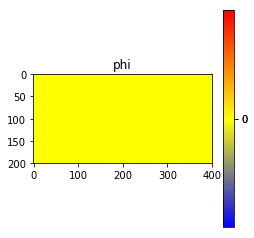

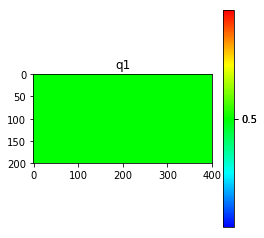

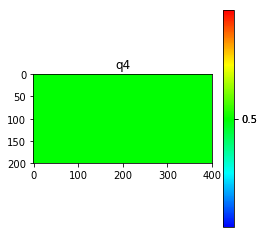

number of nuclei added:  35


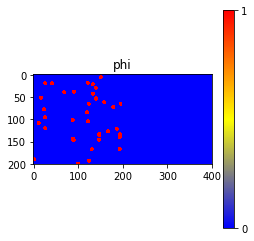

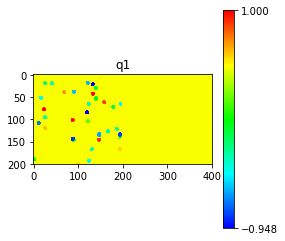

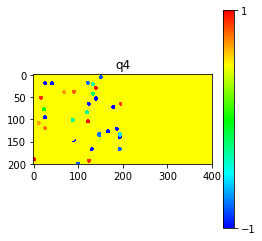

In [14]:
#finding the thermodynamic variables we need for the nucleation algorithm
y1,p11=find_Pn(Tm, T, Q, dt)
#creating phase field arrays for demonstration
phinew=np.full((200, 400), 0)
q1new=np.full((200, 400), 0.5)
q4new=np.full((200, 400), 0.5)

#plotting the images before and after the nucleation algorithm
plotImages_q(phinew, q1new, q4new)
phinew, q1new, q4new=add_nuclei(phinew,q1new,q4new, p11, 200, 400)
plotImages_q(phinew, q1new, q4new)

- The different colors in the nuclei show that their orientation is random.
- The number of nuclei added confirms our expectations for the temperature dependence.
## IV. Combined Approach
- In the combined approach, every 500 iterations, a nucleation step is included.
- The simulation code includes Brownian Motion as outlined for the case inside the functional.
- I incorporated the nucleation demonstrated above in the phase field engine written by Scott Peters.
```python
#This code segment saves the arrays every 500 steps
        #it also adds nuclei
        if(step%500 == 0):
            #find the stochastic nucleation critical probabilistic cutoff
            #attn -- Q and T_liq are hard coded parameters for Ni-10%Cu
            Q0=8*10**5 #activation energy of migration
            T_liq=1697 #Temperature of Liquidus (K)
            J0,p11=utils.find_Pn(T_liq, T, Q0, dt) 
            phi, q1, q4=utils.add_nuclei(phi, q1, q4, p11, len(phi))
            utils.saveArrays_nc(data_path, step, phi, c, q1, q4)
```
- An illustrative example of inserting extra nuclei is shown below, with the Brownian Motion noise term, and a higher nucleation density than realistic at 1574K for the sake of demonstration.
- Below are shown the concentration of Aluminum in a three component model, as well as the quaternion. Time progresses to the right, pictures above each other are at the same timestep.
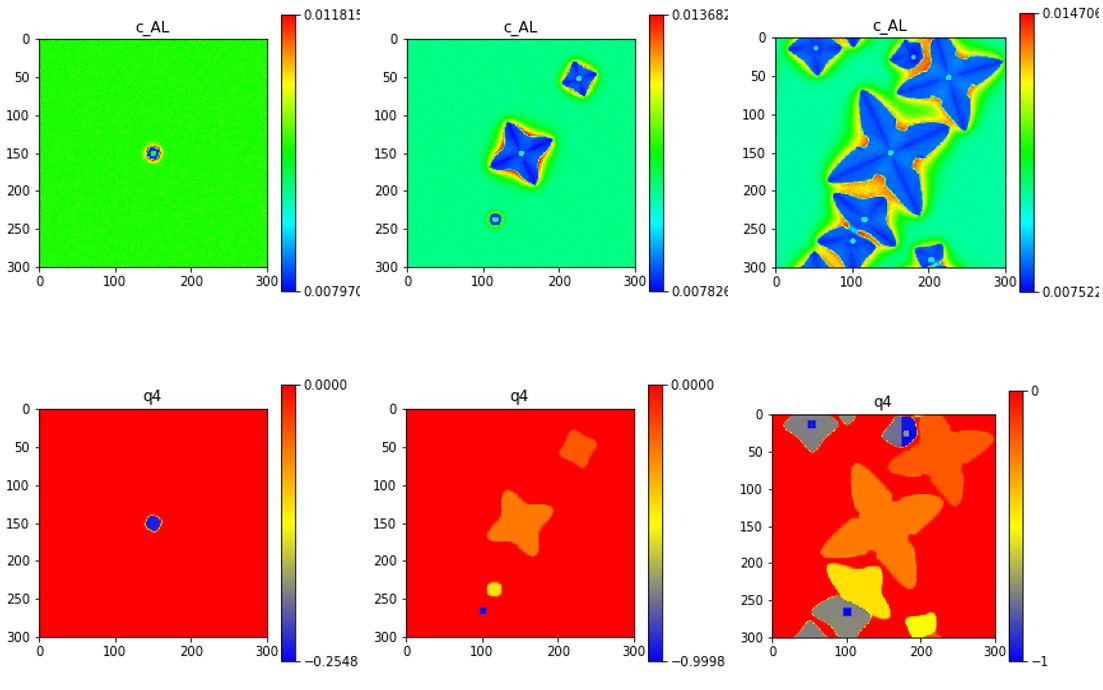
$$ Figure\_3$$

## V. Conclusions and Outlook 
### Brownian Motion
- The noise term in Spinodal Decomposition shouldn't be seen as diffusion limited.
- The results for solidification seem valid for the noise inside the functional.
- The assumptions made when adding the noise outside the functional seem to be invalid for multi component models.
- The result of the final algorithm is optically similar to the model before adding the Langevin noise term, but the amplitudes of extrema are larger. 

### Stochastic Nucleation
- Nucleation probabilities could be reproduced for Ni-10%Cu
- For a different alloy: Activation Energy of migration and temperature of the liquidus can be changed, but we also need to determine $k_1$ and $k_2$. 
- Further reading$^{[7]}$ will be helpful to obtain parameters for different alloys.
- Nucleation rate shows a strong temperature dependence.
- The current algorithm forms nuclei with completely random orientations.

### Personal Learning Outcome
As part of my undergraduate research project, I would like to highlight the learning outcomes for me as a student from working on this project for approximately three months. After completing this project, I am under the impression that I benefitted most from:
- Writing simulations starting from governing energy equations
- Generating arrays of random numbers for corresponding arrays of Gaussian or Poisson statistics
- Understanding concepts from materials science, i.e. solidification, nucleation, Brownian motion
- Presenting and communicating research process to group members and cooperation partners (NASA)

## References
[1] Zwanzig, Robert. "1.1 Langevin Equation and the Fluctuation Dissipation Theorem". Nonequilibrium statistical mechanics. Oxford University Press, 2001.  
[2] Drolet, François, K. R. Elder, Martin Grant, and J. M. Kosterlitz. "Phase-field modeling of eutectic growth." Physical Review E 61, no. 6 (2000): 6705.  
[3] Box, George EP. "A note on the generation of random normal deviates." Ann. Math. Stat. 29 (1958): 610-611.     
[4] Cahn, John W., and John E. Hilliard. "Free energy of a nonuniform system. I. Interfacial free energy." The Journal of chemical physics 28, no. 2 (1958): 258-267.  
[5] Cook, H. E. "Brownian motion in spinodal decomposition." Acta metallurgica 18, no. 3 (1970): 297-306.  
[6] Fu, Yao, John Michopoulos, and Balachander Gnanasekaran. "Microstructure evolution under isothermal and continuous cooling conditions via a combined multiphase field and nucleation approach." Computational Materials Science 155 (2018): 457-465. 
[7] Wen, Y. H., J. P. Simmons, C. Shen, C. Woodward, and Y. Wang. "Phase-field modeling of bimodal particle size distributions during continuous cooling." Acta materialia 51, no. 4 (2003): 1123-1132.